In [35]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import scipy.io as sio

import re
import io


import mne

In [36]:
from typing import Optional, Tuple, Dict, Any

## Import Dataset
* Ch1 - FC3  
* Ch2 - FCz
* Ch3 - FC4 
* Ch4 - C5  
* Ch5 - C3  
* Ch6 - C1     
* Ch7 - Cz 
* Ch8 - C2
* Ch9 - C4
* Ch10 - C6
* Ch11 - CP3 
* Ch12 - CP1
* Ch13 - CPz
* Ch14 - CP2
* Ch15 - CP4
* Ch16 - Pz

In [37]:
def _todict(matobj):
    """
    Convert MATLAB structs to nested Python dicts.
    Handles simple nested structs returned by scipy.io.loadmat with
    struct_as_record=False and squeeze_me=True
    """
    result = {}
    for fieldname in matobj._fieldnames:
        elem = getattr(matobj, fieldname)
        if hasattr(elem, "_fieldnames"):
            result[fieldname] = _todict(elem)
        else:
            result[fieldname] = elem
    return result


def _check_and_unpack(value):
    """
    If value is a numpy void/record or matlab object, unpack into dict/list/ndarray.
    """
    # matlab object (mat_struct) instance
    if hasattr(value, "_fieldnames"):
        return _todict(value)
    # numpy array of objects, maybe from struct array
    if isinstance(value, np.ndarray) and value.dtype == np.object_:
        try:
            # try to squeeze and take the first element if it looks like a struct wrapper
            squeezed = np.squeeze(value)
            if hasattr(squeezed, "_fieldnames"):
                return _todict(squeezed)
            return squeezed
        except Exception:
            return value
    return value


def load_mat_to_dataframe(
    path: str,
    y_name: Optional[str] = None,
    trig_name: Optional[str] = None,
    expected_n_channels: Optional[int] = None,
    channel_names: Optional[list] = None,
    return_meta: bool = False,
    verbose: bool = False,
) -> Tuple[pd.DataFrame, Optional[Dict[str, Any]]]:
    """
    Load .mat file and return a pandas DataFrame with channels and trig column.

    Parameters
    ----------
    path : str
        Path to the .mat file.
    y_name : str, optional
        Name of variable in .mat containing the signal array.
        If None, function will attempt to auto-detect the main 2D array.
    trig_name : str, optional
        Name of trigger/event vector in .mat. If None, function will try common names
        or match by length to the signal.
    expected_n_channels : int, optional
        Hint for how many channels the signal has, e.g. 16. Helps selection if multiple 2D arrays exist.
    channel_names : list, optional
        List of channel names of length n_channels. If None, channel names will be ch1, ch2, ...
    return_meta : bool, optional
        If True, return a second value with meta info (selected variable names, shapes).
    verbose : bool, optional
        Print debug info.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame with shape (n_samples, n_channels + 1), last column named 'trig'
    meta : dict or None
        When return_meta True, returns { 'y_name':..., 'trig_name':..., 'shapes': {...} }
    """
    mat = sio.loadmat(path, struct_as_record=False, squeeze_me=True)

    # clean keys
    keys = [k for k in mat.keys() if not k.startswith("__")]
    if verbose:
        print("Variables found in .mat:", keys)

    # helper to collect candidate arrays
    candidates = {}
    for k in keys:
        val = mat[k]
        val = _check_and_unpack(val)
        candidates[k] = val

    # find y (2D signal)
    y = None
    chosen_y_name = None

    if y_name and y_name in candidates:
        y = candidates[y_name]
        chosen_y_name = y_name
    else:
        # try names that hint at signal
        prefer_names = ["y", "data", "signals", "eeg", "eeg_data", "X", "val"]
        for name in prefer_names:
            if name in candidates and isinstance(candidates[name], np.ndarray) and candidates[name].ndim >= 2:
                y = candidates[name]
                chosen_y_name = name
                break

    # fallback: pick the largest 2D numeric array, or the one matching expected_n_channels
    if y is None:
        two_d_arrays = {k: v for k, v in candidates.items() if isinstance(v, np.ndarray) and v.ndim == 2}
        if verbose:
            print("2D arrays found:", {k: v.shape for k, v in two_d_arrays.items()})
        if expected_n_channels is not None:
            # prefer array with one dimension equal to expected_n_channels
            for k, v in two_d_arrays.items():
                if v.shape[0] == expected_n_channels or v.shape[1] == expected_n_channels:
                    y = v
                    chosen_y_name = k
                    break
        if y is None and two_d_arrays:
            # choose largest by element count
            chosen_y_name, y = max(two_d_arrays.items(), key=lambda kv: kv[1].size)

    if y is None:
        raise ValueError("Could not find a 2D signal array in the .mat file, provide y_name or check the file.")

    # ensure numpy array
    y = np.array(y)

    # shape fix: if channels are rows and expected_n_channels matches first dim, transpose
    if y.ndim != 2:
        raise ValueError(f"Selected signal array {chosen_y_name} is not 2D, got shape {y.shape}")

    n_samples, n_channels = y.shape
    # if it's (channels, samples) swap
    if expected_n_channels is not None and n_channels != expected_n_channels and y.shape[0] == expected_n_channels:
        if verbose:
            print("Transposing y, channels are in rows, not columns.")
        y = y.T
        n_samples, n_channels = y.shape

    # second check: if channels still not as expected but first dim is much larger, assume first dim is samples
    if expected_n_channels is None and n_channels > y.shape[0]:
        # nothing to do, keep as is
        pass

    # find trig
    trig = None
    chosen_trig_name = None
    if trig_name and trig_name in candidates:
        trig = candidates[trig_name]
        chosen_trig_name = trig_name
    else:
        # try common trigger names first
        trig_candidates_names = ["trig", "trigger", "triggers", "event", "events", "markers", "marker"]
        for name in trig_candidates_names:
            if name in candidates:
                val = candidates[name]
                if isinstance(val, np.ndarray) and (val.ndim == 1 or (val.ndim == 2 and 1 in val.shape)):
                    trig = val
                    chosen_trig_name = name
                    break

    # if not found, try arrays that match length
    if trig is None:
        for k, v in candidates.items():
            if isinstance(v, np.ndarray):
                # flatten candidate shapes to length
                if v.ndim == 1 and v.shape[0] == n_samples:
                    trig = v
                    chosen_trig_name = k
                    break
                if v.ndim == 2 and (v.shape[0] == n_samples or v.shape[1] == n_samples):
                    trig = v
                    chosen_trig_name = k
                    break

    if trig is None:
        # no trig found, create a zeros vector and warn
        if verbose:
            print("No trigger vector detected, creating a zero 'trig' column.")
        trig = np.zeros(n_samples, dtype=int)
        chosen_trig_name = None

    # normalize trig shape to 1D
    trig = np.array(trig).squeeze()
    if trig.ndim != 1 or trig.shape[0] != n_samples:
        # try transpose or reshape if it's (n_samples,1) or (1,n_samples)
        if trig.ndim == 2 and (trig.shape[0] == n_samples or trig.shape[1] == n_samples):
            trig = trig.ravel()
        else:
            raise ValueError(f"Trigger vector shape {trig.shape} does not match number of samples {n_samples}")

    # build DataFrame
    if channel_names is not None:
        if len(channel_names) != n_channels:
            raise ValueError("channel_names length does not match number of channels")
        cols = channel_names
    else:
        cols = [f"ch{i+1}" for i in range(n_channels)]

    df = pd.DataFrame(y, columns=cols)
    df["trig"] = trig


    meta = {
        "y_name": chosen_y_name,
        "y_shape": y.shape,
        "trig_name": chosen_trig_name,
        "trig_shape": trig.shape,
        "n_samples": n_samples,
        "n_channels": n_channels,
    }

    if verbose:
        print("Loaded signal", meta)

    if return_meta:
        return df, meta
 
    return df, meta

In [38]:
# Get metadata too
#df, meta = load_mat_to_dataframe("your_file.mat", expected_n_channels=16, return_meta=True)
#print(meta)

# Use explicit variable names if you know them
df, meta = load_mat_to_dataframe("data\P1_pre_training.mat", y_name="y", trig_name="trig", channel_names=[f"ch{i+1}" for i in range(16)])
print(meta)


{'y_name': 'y', 'y_shape': (271816, 16), 'trig_name': 'trig', 'trig_shape': (271816,), 'n_samples': 271816, 'n_channels': 16}


In [39]:
df.head(5)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
0,38001.839844,36892.000000,46397.214844,50350.613281,37726.980469,57036.867188,46999.265625,47667.355469,47781.109375,39447.503906,49432.898438,48651.296875,49362.050781,47384.273438,38979.992188,61820.179688,0
1,54828.550781,54868.156250,52444.156250,52408.507812,54521.210938,50932.191406,52738.488281,52781.171875,52272.847656,54376.527344,52604.574219,52560.785156,52507.796875,52978.863281,54474.457031,50255.472656,0
2,-24629.253906,-24865.400391,-22964.140625,-22914.605469,-24873.259766,-22113.113281,-23516.539062,-23355.142578,-22624.406250,-24587.474609,-23058.496094,-23198.757812,-23129.423828,-23339.222656,-24563.939453,-21289.884766,0
3,-77839.562500,-78191.210938,-76574.710938,-76846.210938,-78150.195312,-76362.351562,-77222.789062,-77171.906250,-76289.273438,-78103.726562,-77080.812500,-77045.546875,-76983.515625,-77237.015625,-77972.484375,-75860.140625,0
4,-48999.753906,-49155.601562,-49435.792969,-49648.988281,-49283.152344,-50093.390625,-49608.496094,-49621.535156,-49217.925781,-49437.320312,-49688.796875,-50009.597656,-49660.007812,-49592.742188,-49244.277344,-50159.144531,0


In [40]:
df.shape

(271816, 17)

In [41]:
df.columns

Index(['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8', 'ch9', 'ch10',
       'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16', 'trig'],
      dtype='object')

In [42]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
count,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000
mean,-158.634849,-62.401942,-393.462122,-1867.455619,-451.789993,-510.357172,-424.919882,-445.915095,-398.677113,-434.922062,-385.399846,-2563.940475,-277.208570,-317.877191,-379.092799,-358.594691,0.000000
std,34555.736787,38064.502172,34636.156238,43374.740135,34809.260035,34773.400111,34697.779470,34865.721134,34670.438628,34757.789417,34809.551029,43789.335316,33992.150741,33911.691735,34098.532450,34048.760973,0.776378
min,-403234.187500,-383352.093750,-404016.250000,-455808.281250,-406625.593750,-405575.156250,-406884.750000,-406483.875000,-402868.875000,-403808.781250,-403821.937500,-457645.718750,-395735.656250,-395571.312500,-394307.937500,-394534.656250,-1.000000
25%,232.641670,64.461695,-37.606057,37.391302,-18.758564,-70.169296,18.684913,-22.009736,25.188777,-84.171661,-3.021342,-42.622512,60.759815,0.082577,-33.289404,-17.288617,-1.000000
50%,256.634674,88.861897,-10.964761,59.308496,1.687507,-47.533743,43.577663,0.426885,50.607193,-60.249186,15.840919,-24.089332,87.887077,33.465153,-15.595930,0.223157,0.000000
75%,370.388687,239.138687,136.366196,89.040525,108.721699,57.051946,177.577412,89.039349,145.125107,79.729914,105.662832,38.486605,227.555447,198.336864,43.761347,105.226824,1.000000
max,358119.812500,345198.812500,358821.812500,376052.437500,359421.937500,358761.125000,359550.250000,359233.468750,357844.656250,357395.718750,357450.281250,373367.250000,355197.500000,354565.718750,354573.937500,353794.156250,1.000000


In [43]:
df['trig'].nunique()

3

In [44]:
df[df['trig'] == -1]

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
65838,599.143921,372.026001,281.206818,145.661758,175.493774,291.693695,356.972168,230.760513,234.908661,256.582001,192.171509,132.183365,448.610291,523.696716,158.340958,197.838867,-1
65839,590.737305,361.050690,268.419586,130.823792,150.245514,268.407043,332.262146,216.259171,222.842331,244.881943,177.966324,125.428322,435.948364,501.930084,150.129852,192.365173,-1
65840,611.666809,376.292084,288.996887,151.781876,167.275955,289.666931,357.749603,237.573914,243.092819,262.182739,200.732285,146.401184,453.051086,522.689636,162.566895,192.647720,-1
65841,595.159241,361.700928,268.992371,130.855682,155.956116,275.761078,342.734894,218.474091,221.565277,246.658127,178.025574,109.876862,432.919128,486.806580,154.137604,190.529251,-1
65842,600.869507,374.406647,283.435883,150.169312,166.620850,277.407806,348.804474,234.009842,241.137817,262.942566,199.974701,141.113037,454.170380,511.270294,165.405884,190.998077,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271795,242.781525,67.049637,-19.068010,70.790031,-19.983019,-56.141350,12.221759,-15.530634,35.991051,-80.896461,7.147117,-39.770390,64.709167,-7.892024,-22.693344,-13.952981,-1
271796,215.742676,53.115944,-36.236279,55.332569,-31.691547,-86.276329,-3.875594,-34.907341,18.115387,-94.078728,-6.348837,-48.067036,49.096142,-6.562933,-33.956944,-22.609144,-1
271797,227.186951,65.063400,-25.860865,65.729813,-30.707947,-76.613670,2.796699,-21.934059,29.927046,-83.115623,4.164769,-50.817680,62.357845,-5.930853,-26.676371,-19.922352,-1
271798,224.690292,57.086212,-30.261307,60.743656,-20.344366,-78.378143,2.439494,-28.684645,21.184464,-91.093040,-6.866218,-42.286804,53.596783,-6.648259,-28.449129,-19.770422,-1


In [45]:
df[df['trig'] == -1].value_counts().sum()

81920

In [46]:
df[df['trig'] == 1]

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
78019,538.407776,284.577942,217.008270,144.951645,102.956032,160.371689,266.511169,135.629776,176.695282,122.448891,121.219856,52.823376,281.868927,304.229675,63.344437,95.076012,1
78020,550.695740,295.105438,225.427490,153.456604,99.815903,172.223312,273.248962,148.608765,185.736984,130.632568,122.309441,47.292412,292.681396,307.453430,64.446022,81.637375,1
78021,563.211975,303.441254,235.341415,162.252563,95.773018,200.389191,287.629272,156.012405,195.468185,138.800293,133.540527,62.812519,301.962921,332.096161,71.698067,100.078918,1
78022,540.694275,282.758179,214.209747,141.492157,92.394684,181.384933,265.352020,133.570923,168.979721,119.109192,118.248795,63.884270,274.851990,311.895203,55.679478,103.864632,1
78023,564.948181,310.085175,243.840195,170.754883,107.687920,210.079819,292.598755,161.604614,201.584869,145.799149,142.130280,67.299446,307.015381,348.632050,74.334740,106.812218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259019,233.126755,63.924778,-33.429794,60.262287,-31.576845,-69.694893,21.729639,-15.273890,31.474510,-88.887428,7.060484,-34.103172,60.574394,-3.637934,-16.947046,-6.880708,1
259020,235.115479,64.153412,-39.183231,59.895462,-28.405546,-69.599243,22.252895,-13.396914,30.261585,-90.566498,2.993686,-41.077267,61.183144,-5.229909,-16.334063,-5.503847,1
259021,234.167313,62.850479,-39.086857,63.098255,-34.388950,-57.915405,23.725485,-11.671236,33.615913,-90.613136,4.748469,-44.786137,61.070824,-1.697847,-22.236673,-12.567877,1
259022,223.164215,51.272194,-48.733780,51.004906,-38.531132,-68.939285,12.301775,-27.540352,17.515860,-101.280464,-4.824706,-46.925003,49.078785,-10.604307,-24.255993,-7.278707,1


In [47]:
df[df['trig'] == 1].value_counts().sum()

81920

In [48]:
right_imagery_index = list(df[df['trig'] == -1].index)
right_imagery = df[df['trig'] == -1]
print("right Imagery is",df[df['trig'] == -1].value_counts().sum(), "starting from", list(df[df['trig'] == -1].index)[0] )

right Imagery is 81920 starting from 65838


In [49]:
left_imagery_index = list(df[df['trig'] == 1].index)
left_imagery = df[df['trig'] == 1]
print("Left Imagery is",df[df['trig'] == 1].value_counts().sum(), "starting from", list(df[df['trig'] == 1].index)[0] )

Left Imagery is 81920 starting from 78019


In [50]:
zero_imagery_index = list(df[df['trig'] == 0].index)
zero_imagery = df[df['trig'] == 0]
print("Zero Imagery is",df[df['trig'] == 0].value_counts().sum(), "starting from", list(df[df['trig'] == 0].index)[0] )

Zero Imagery is 107976 starting from 0


## Convert to Microvolts

converts raw EEG data from a 24-bit ADC (ranging from 0 to 16777215) into microvolts by normalizing the data,
scaling it to a 4.5V reference voltage, and converting to microvolts,
then rounding to two decimal places. This transformation is necessary for accurately interpreting EEG signals, which are typically measured in microvolts 

In [51]:
# target names, channels 1 to 16
exg_cols = [f"ch{i}" for i in range(1, 17)]

# keep only the EXG columns that actually exist in df_imagine
exg_present = [c for c in exg_cols if c in df.columns]

if not exg_present:
    raise ValueError("No ch Channel columns found in df_imagine.")

# get integer array, handle possible NaNs safely
arr = df[exg_present].fillna(0).to_numpy(dtype=np.int64)

# convert unsigned 32 bit values to signed two's complement where needed
mask = arr >= 2**23
arr[mask] = arr[mask] - 2**24

# convert to microvolts, round to 2 decimals
df[exg_present] = np.round(1000000 * 4.5 * (arr / 16777216), 2)  # 2**32 = 16777216

display(df.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
0,10192.66,9895.21,12444.65,13504.92,10118.90,15298.25,12606.11,12785.29,12815.86,10580.51,13258.70,13049.22,13239.92,12709.38,10454.98,16581.42,0
1,14706.02,14716.74,14066.58,14056.92,14623.67,13661.03,14145.43,14156.97,14020.44,14584.78,14109.49,14097.69,14083.47,14209.81,14611.07,13479.44,0
2,-6606.01,-6669.31,-6159.42,-6146.01,-6671.46,-5931.17,-6307.48,-6264.30,-6068.23,-6594.75,-6184.64,-6222.19,-6203.68,-6260.01,-6588.31,-5710.15,0
3,-20878.05,-20972.46,-20538.75,-20611.70,-20961.46,-20481.88,-20712.55,-20698.88,-20462.30,-20948.86,-20674.47,-20665.08,-20648.45,-20716.58,-20913.72,-20347.24,0
4,-13142.56,-13184.40,-13259.50,-13316.63,-13218.73,-13435.99,-13305.90,-13309.39,-13201.03,-13260.04,-13327.36,-13413.46,-13319.85,-13301.61,-13208.27,-13453.69,0


## Visualisation

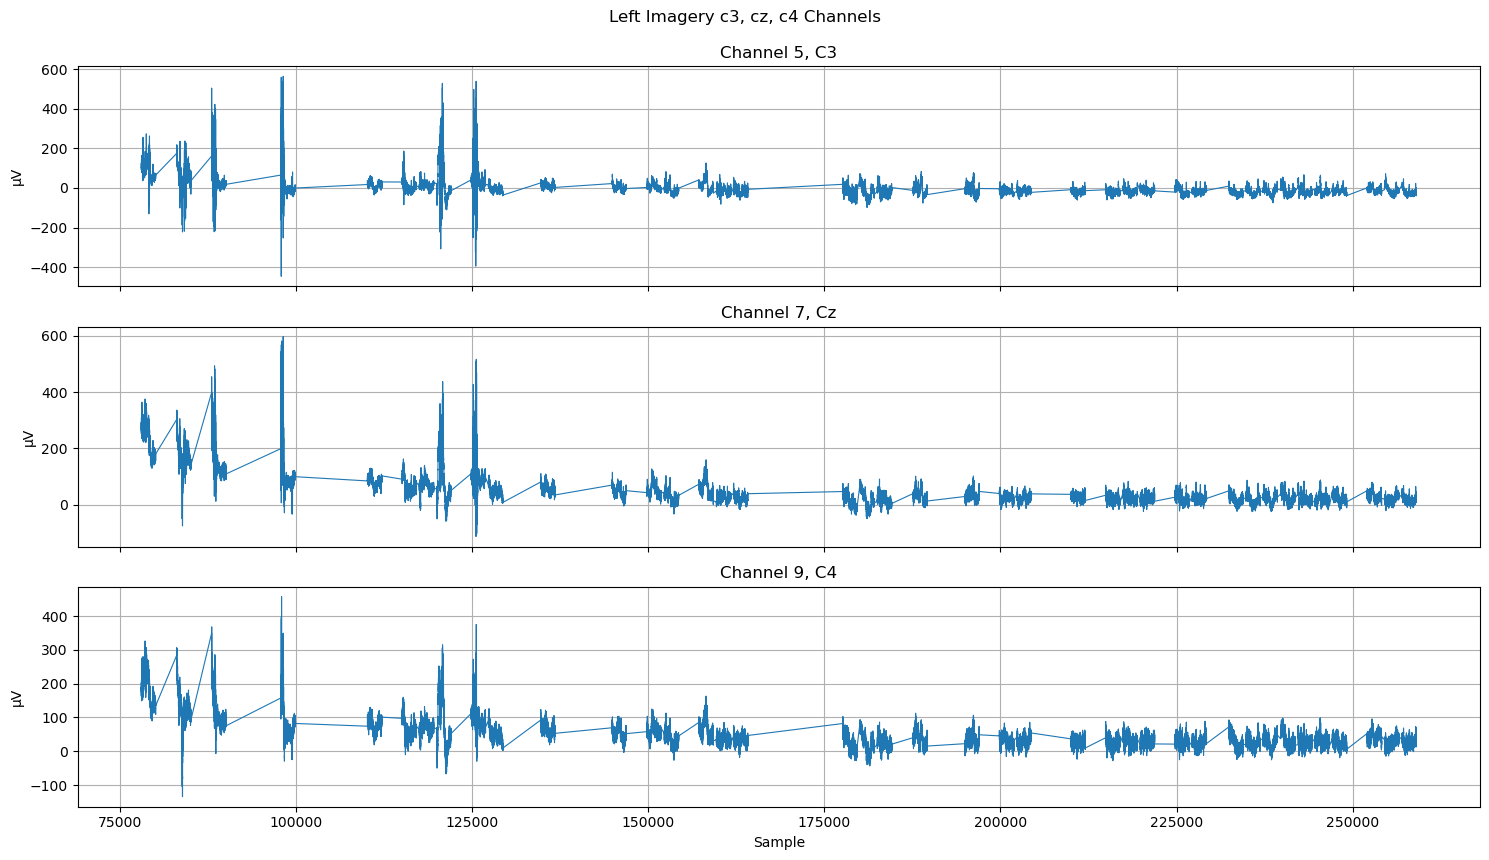

In [52]:
## Left imagery visual
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15,9), sharex=True)
axes = axes.flatten()

axes[0].plot(left_imagery['ch5'], linewidth=0.8)
axes[0].set_title("Channel 5, C3")
axes[0].grid(True)
axes[0].set_ylabel("µV")

axes[1].plot(left_imagery['ch7'], linewidth=0.8)
axes[1].set_title("Channel 7, Cz")
axes[1].grid(True)
axes[1].set_ylabel("µV")

axes[2].plot(left_imagery['ch9'], linewidth=0.8)
axes[2].set_title("Channel 9, C4")
axes[2].grid(True)
axes[2].set_ylabel("µV")


fig.suptitle("Left Imagery c3, cz, c4 Channels", y=0.95)
plt.xlabel("Sample")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

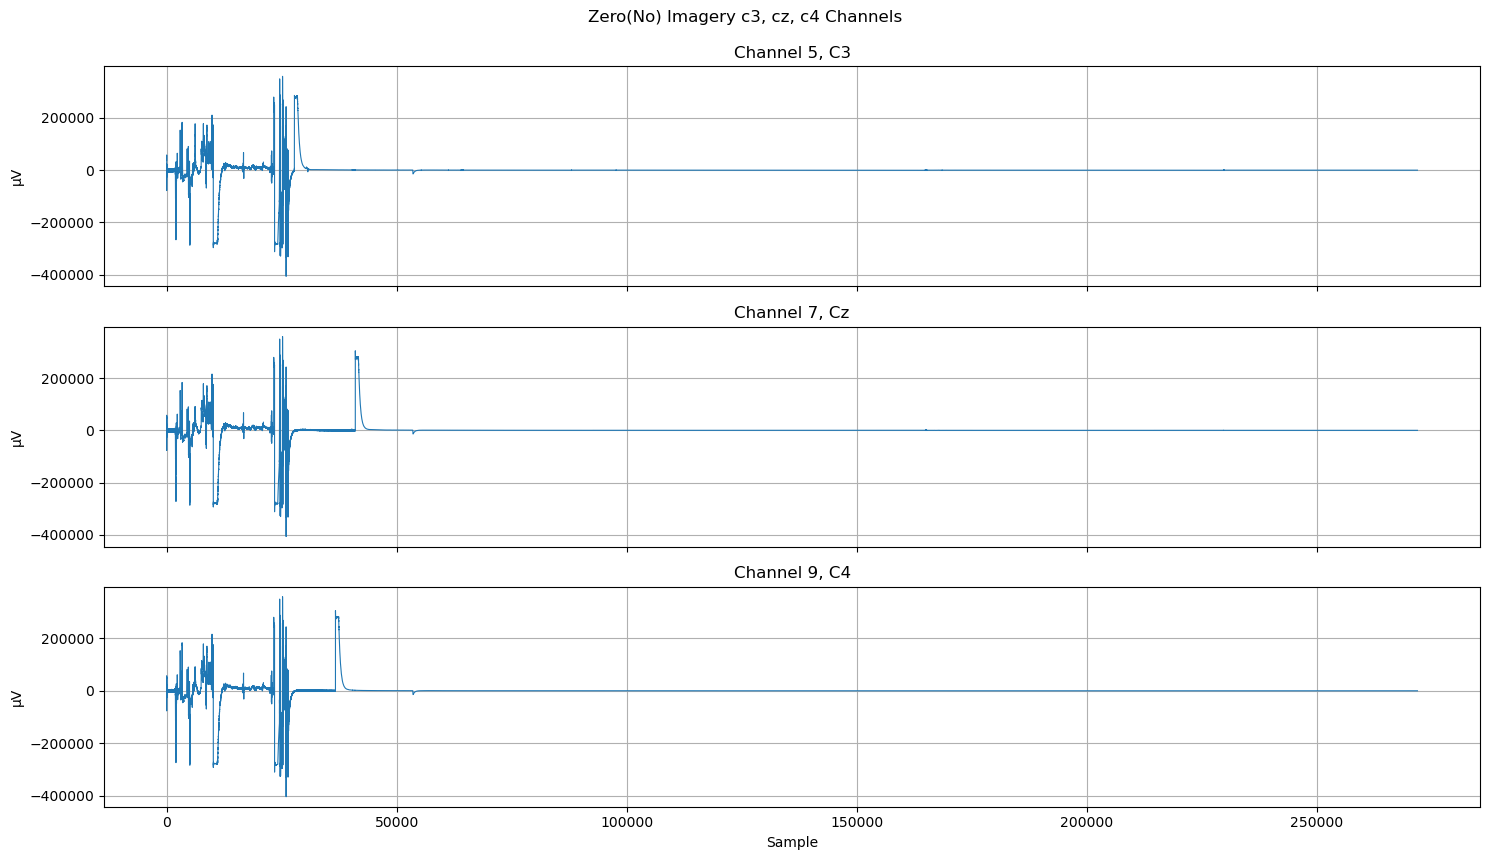

In [53]:
## Zero or NO imagery visual
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15,9), sharex=True)
axes = axes.flatten()

axes[0].plot(zero_imagery['ch5'], linewidth=0.8)
axes[0].set_title("Channel 5, C3")
axes[0].grid(True)
axes[0].set_ylabel("µV")

axes[1].plot(zero_imagery['ch7'], linewidth=0.8)
axes[1].set_title("Channel 7, Cz")
axes[1].grid(True)
axes[1].set_ylabel("µV")

axes[2].plot(zero_imagery['ch9'], linewidth=0.8)
axes[2].set_title("Channel 9, C4")
axes[2].grid(True)
axes[2].set_ylabel("µV")


fig.suptitle("Zero(No) Imagery c3, cz, c4 Channels", y=0.95)
plt.xlabel("Sample")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

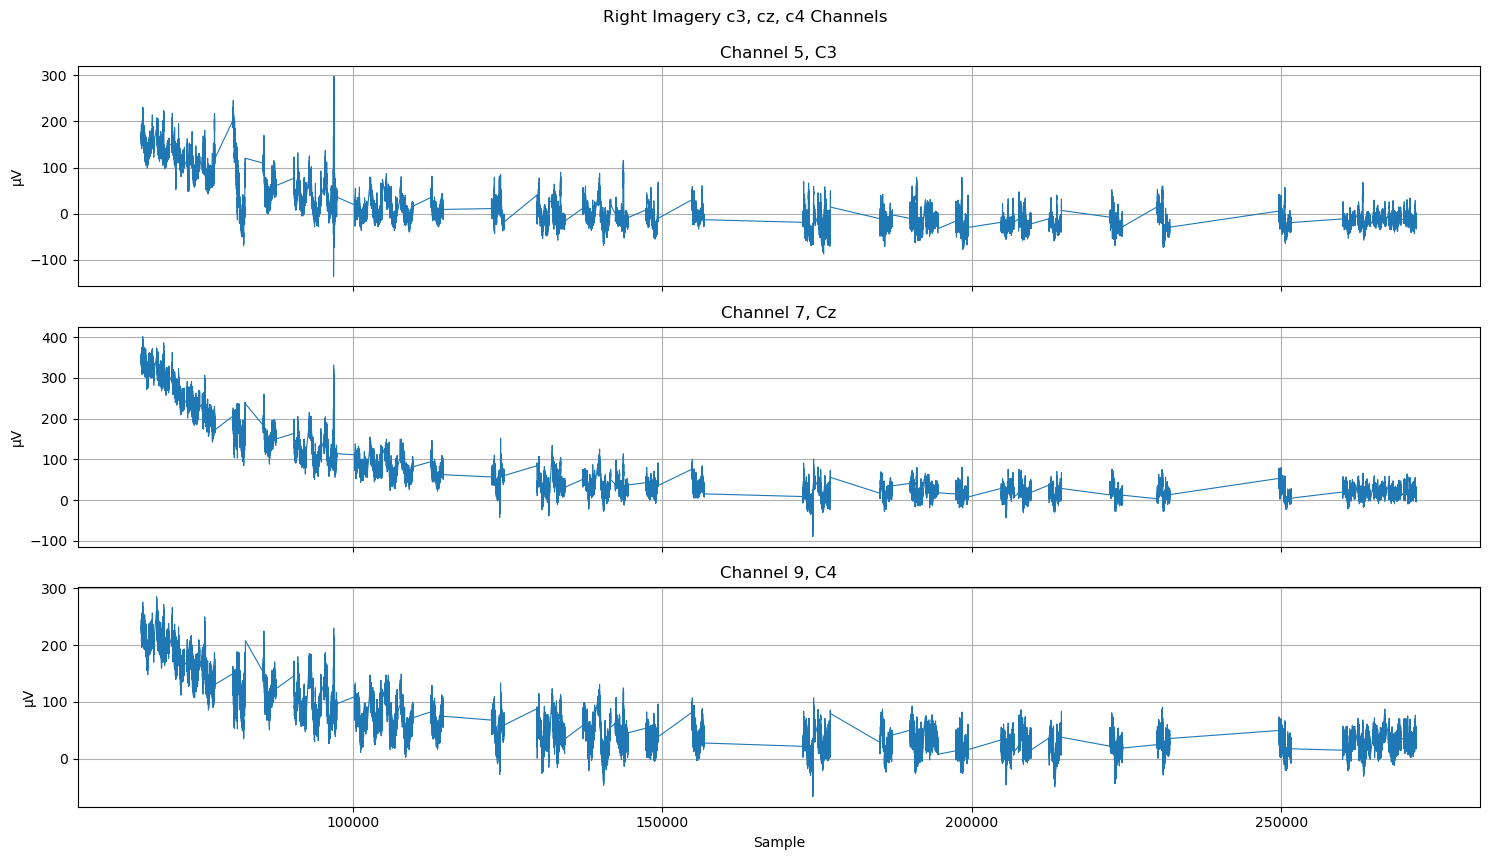

In [54]:
## Right imagery visual
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15,9), sharex=True)
axes = axes.flatten()

axes[0].plot(right_imagery['ch5'], linewidth=0.8)
axes[0].set_title("Channel 5, C3")
axes[0].grid(True)
axes[0].set_ylabel("µV")

axes[1].plot(right_imagery['ch7'], linewidth=0.8)
axes[1].set_title("Channel 7, Cz")
axes[1].grid(True)
axes[1].set_ylabel("µV")

axes[2].plot(right_imagery['ch9'], linewidth=0.8)
axes[2].set_title("Channel 9, C4")
axes[2].grid(True)
axes[2].set_ylabel("µV")


fig.suptitle("Right Imagery c3, cz, c4 Channels", y=0.95)
plt.xlabel("Sample")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Drop all channles except C3, C4, Cz before it is the motor cortex area we will be focusing in this context

In [55]:
columns_to_drop = ['ch1', 'ch2','ch3','ch4','ch6','ch8','ch10','ch11','ch12','ch13','ch14','ch15','ch16']
left_imagery =  left_imagery.drop(columns_to_drop, axis=1)
left_imagery.head(2)

,ch5,ch7,ch9,trig
78019,102.956032,266.511169,176.695282,1
78020,99.815903,273.248962,185.736984,1


In [56]:
#columns_to_drop = ['ch1', 'ch2','ch3','ch4','ch6','ch8','ch10','ch11','ch12','ch13','ch14','ch15','ch16']
#right_imagery =  right_imagery.drop(columns_to_drop, axis=1)
right_imagery.head(2)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
65838,599.143921,372.026001,281.206818,145.661758,175.493774,291.693695,356.972168,230.760513,234.908661,256.582001,192.171509,132.183365,448.610291,523.696716,158.340958,197.838867,-1
65839,590.737305,361.050690,268.419586,130.823792,150.245514,268.407043,332.262146,216.259171,222.842331,244.881943,177.966324,125.428322,435.948364,501.930084,150.129852,192.365173,-1


In [57]:
columns_to_drop = ['ch1', 'ch2','ch3','ch4','ch6','ch8','ch10','ch11','ch12','ch13','ch14','ch15','ch16']
zero_imagery =  zero_imagery.drop(columns_to_drop, axis=1)
zero_imagery.head(2)

,ch5,ch7,ch9,trig
0,37726.980469,46999.265625,47781.109375,0
1,54521.210938,52738.488281,52272.847656,0


## Pre Processing

##
* Ch5 - C3  
* Ch7 - Cz  
* Ch9 - C4 

# Temporal Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.

Band-pass Filtering Functions

The script defines Butterworth low-pass and high-pass filters using SciPy:

- butter_lowpass and butter_highpass create filter coefficients based on cutoff frequencies and sampling rate (fs).

- butter_lowpass_filter and butter_highpass_filter apply these filters to the EEG signal data.

- High-pass filters remove low-frequency noise below the cutoff.

- Low-pass filters remove high-frequency noise above the cutoff.

Combining high-pass followed by low-pass creates a band-pass filter, isolating the EEG signal frequencies of interest.
A bandpass filter + notch filter
8 - 30 Hz

In [58]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b,a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

Bandpass filter of 8 to 30 HZ  for the left imagery

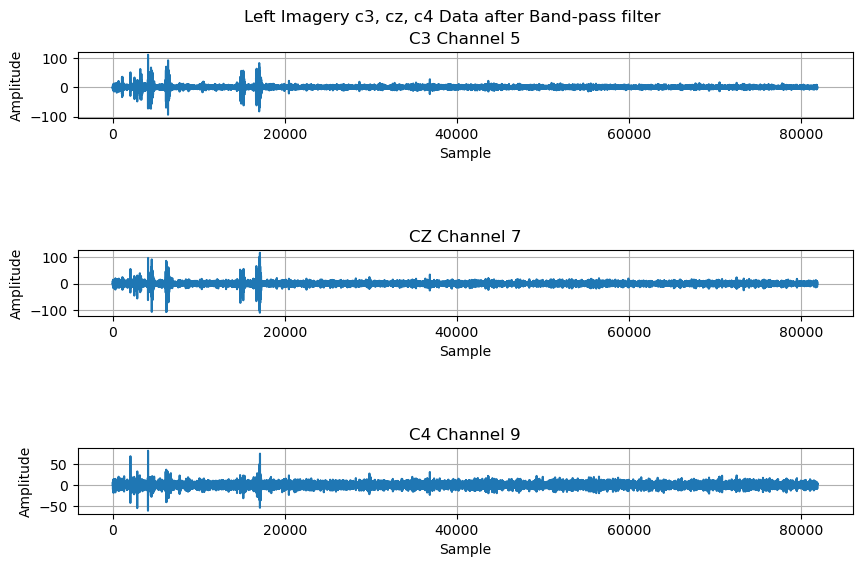

In [59]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)
plt.suptitle("Left Imagery c3, cz, c4 Data after Band-pass filter", y=0.95)

axis[0].set_title('C3 Channel 5')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0
fps = 256
lowcut = 30
highcut = 8

#  data_for_graph = dataset
ch_5_high = butter_highpass_filter(left_imagery['ch5'], highcut, fps)
ch_5_band_pass = butter_lowpass_filter(ch_5_high, lowcut, fps)

ch_7_high = butter_highpass_filter(left_imagery['ch7'], highcut, fps)
ch_7_band_pass = butter_lowpass_filter(ch_7_high, lowcut, fps)

ch_9_high = butter_highpass_filter(left_imagery['ch9'], highcut, fps)
ch_9_band_pass = butter_lowpass_filter(ch_9_high, lowcut, fps)


axis[0].plot(ch_5_band_pass)
axis[1].plot(ch_7_band_pass)
axis[2].plot(ch_9_band_pass)
plt.show()



In [60]:

left_imagery_band_pass = pd.DataFrame({
        'C3 Channel 5': ch_5_band_pass,
        'Cz Channel 7': ch_7_band_pass,
        'C4 Channel 9': ch_9_band_pass,
        'trig' : left_imagery['trig']
})

# 3) Basic inspections
print("shape:", left_imagery_band_pass.shape)   # rows, columns
print("columns:", left_imagery_band_pass.columns.tolist())

# 4) show head and tail
display(left_imagery_band_pass.head())
display(left_imagery_band_pass.tail())

shape: (81920, 4)
columns: ['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9', 'trig']


,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
78019,0.002449,0.002562,0.001325,1
78020,0.010399,0.035767,0.030434,1
78021,-0.018470,0.241858,0.231916,1
78022,-0.273489,0.953056,0.911436,1
78023,-1.087078,2.494759,2.263048,1


,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
259019,0.034866,0.228762,5.104809,1
259020,0.583315,0.490912,3.697723,1
259021,0.787654,0.439609,1.185096,1
259022,0.194670,-0.235748,-2.148419,1
259023,-1.294025,-1.483525,-5.747327,1


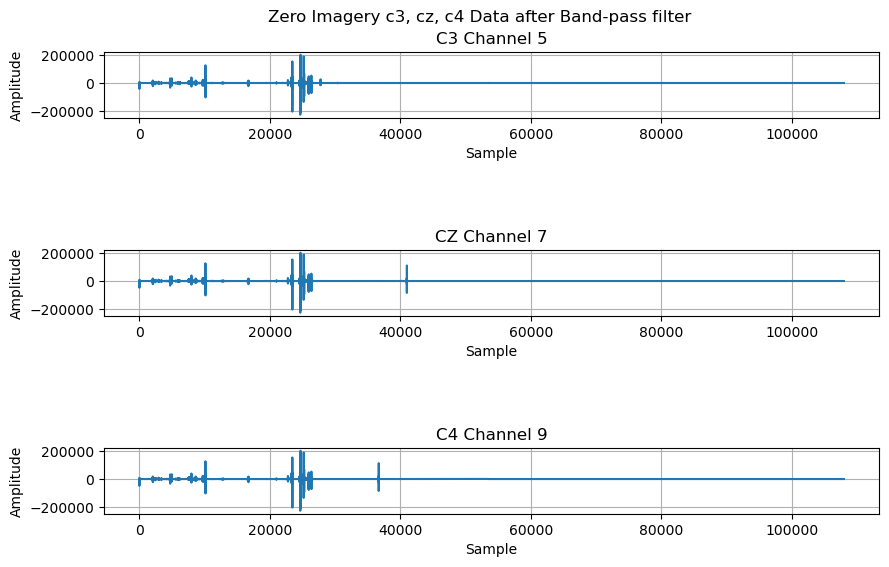

In [61]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)
plt.suptitle("Zero Imagery c3, cz, c4 Data after Band-pass filter", y=0.95)

axis[0].set_title('C3 Channel 5')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0
fps = 256
lowcut = 30
highcut = 8

#  data_for_graph = dataset
ch_5_high = butter_highpass_filter(zero_imagery['ch5'], highcut, fps)
ch_5_band_pass = butter_lowpass_filter(ch_5_high, lowcut, fps)

ch_7_high = butter_highpass_filter(zero_imagery['ch7'], highcut, fps)
ch_7_band_pass = butter_lowpass_filter(ch_7_high, lowcut, fps)

ch_9_high = butter_highpass_filter(zero_imagery['ch9'], highcut, fps)
ch_9_band_pass = butter_lowpass_filter(ch_9_high, lowcut, fps)


axis[0].plot(ch_5_band_pass)
axis[1].plot(ch_7_band_pass)
axis[2].plot(ch_9_band_pass)
plt.show()



In [62]:

zero_imagery_band_pass = pd.DataFrame({
        'C3 Channel 5': ch_5_band_pass,
        'Cz Channel 7': ch_7_band_pass,
        'C4 Channel 9': ch_9_band_pass,
        'trig' : zero_imagery['trig']
})

# 3) Basic inspections
print("shape:", zero_imagery_band_pass.shape)   # rows, columns
print("columns:", zero_imagery_band_pass.columns.tolist())

# 4) show head and tail
display(zero_imagery_band_pass.head())
display(zero_imagery_band_pass.tail())

shape: (107976, 4)
columns: ['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9', 'trig']


,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
0,2.340427,2.241113,2.193935,0
1,74.720702,49.101113,45.789950,0
2,367.126675,160.640904,137.520295,0
3,429.602469,-366.800757,-443.086816,0
4,-2009.494668,-3978.640888,-4132.282926,0


,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
271811,1.307517,1.666022,4.152828,0
271812,4.971832,-0.273728,4.891983,0
271813,7.421923,-2.592409,4.408492,0
271814,8.333458,-4.564320,2.985083,0
271815,7.846889,-5.502828,1.274941,0


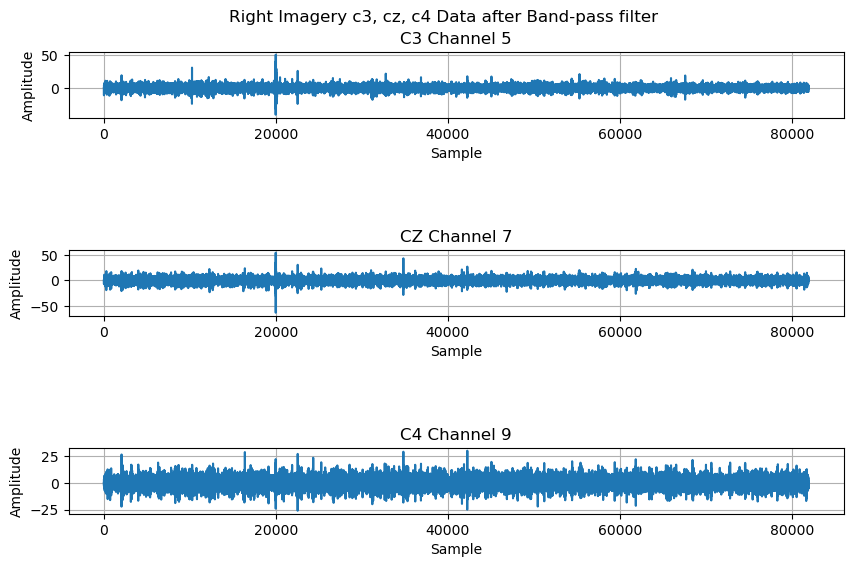

In [63]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)
plt.suptitle("Right Imagery c3, cz, c4 Data after Band-pass filter", y=0.95)

axis[0].set_title('C3 Channel 5')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0
fps = 256
lowcut = 30
highcut = 8

#  data_for_graph = dataset
ch_5_high = butter_highpass_filter(right_imagery['ch5'], highcut, fps)
ch_5_band_pass = butter_lowpass_filter(ch_5_high, lowcut, fps)

ch_7_high = butter_highpass_filter(right_imagery['ch7'], highcut, fps)
ch_7_band_pass = butter_lowpass_filter(ch_7_high, lowcut, fps)

ch_9_high = butter_highpass_filter(right_imagery['ch9'], highcut, fps)
ch_9_band_pass = butter_lowpass_filter(ch_9_high, lowcut, fps)


axis[0].plot(ch_5_band_pass)
axis[1].plot(ch_7_band_pass)
axis[2].plot(ch_9_band_pass)
plt.show()



In [64]:

right_imagery_band_pass = pd.DataFrame({
        'C3 Channel 5': ch_5_band_pass,
        'Cz Channel 7': ch_7_band_pass,
        'C4 Channel 9': ch_9_band_pass,
        'trig' : right_imagery['trig']
})

# 3) Basic inspections
print("shape:", right_imagery_band_pass.shape)   # rows, columns
print("columns:", right_imagery_band_pass.columns.tolist())

# 4) show head and tail
display(right_imagery_band_pass.head())
display(right_imagery_band_pass.tail())

shape: (81920, 4)
columns: ['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9', 'trig']


,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
65838,0.001906,0.001931,0.000814,-1
65839,-0.044044,-0.042297,-0.022972,-1
65840,-0.408878,-0.373388,-0.178963,-1
65841,-1.607360,-1.375056,-0.604798,-1
65842,-3.961039,-3.139924,-1.293802,-1


,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
271795,0.860249,-0.954216,0.899923,-1
271796,0.867680,0.100741,0.965384,-1
271797,1.246837,1.162637,1.202016,-1
271798,1.930397,1.746727,1.490692,-1
271799,2.688062,1.493283,1.603185,-1


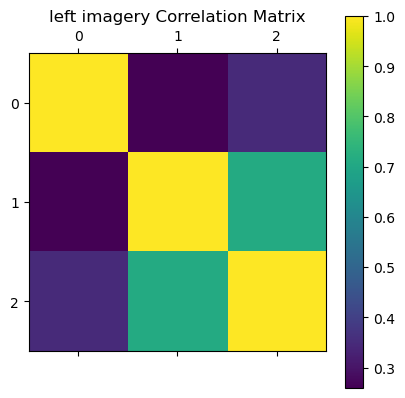

In [68]:
plt.matshow(left_imagery_band_pass[['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9']].corr())
plt.colorbar()
plt.title('left imagery Correlation Matrix')
plt.show()

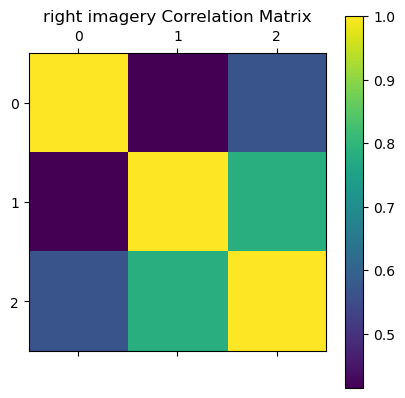

In [69]:

plt.matshow(right_imagery_band_pass[['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9']].corr())
plt.colorbar()
plt.title('right imagery Correlation Matrix')
plt.show()

## Feature Extraction

**Remove Anomaly after band pass-filter**

How the Script Works:.

- Anomaly Removal: Applies a strict filter that keeps only EEG readings between -100 and +100 microvolts across all channels, removing rows with unusually high or low amplitudes (potential anomalies or noise).


Why This Is Important:
- EEG signals often contain noise or artifacts that appear as abnormally large amplitude spikes.

- Removing these anomalies helps improve the quality and reliability of the EEG data.

- Clean data leads to better performance when applying machine learning or further EEG analysis.

- Setting a strict amplitude threshold ensures that only physiologically plausible signals remain.

## Only left and right imagery bandpassed data will be used moving forward

In [70]:
# --- Updated: Strict filtering between -100 and +100 ---
def filter_band_pass_data_strict(df, threshold=100):
    mask = ((df >= -threshold) & (df <= threshold)).all(axis=1)
    return df[mask]

# Apply filtering
left_imagery_band_pass_filtered = filter_band_pass_data_strict(left_imagery_band_pass)

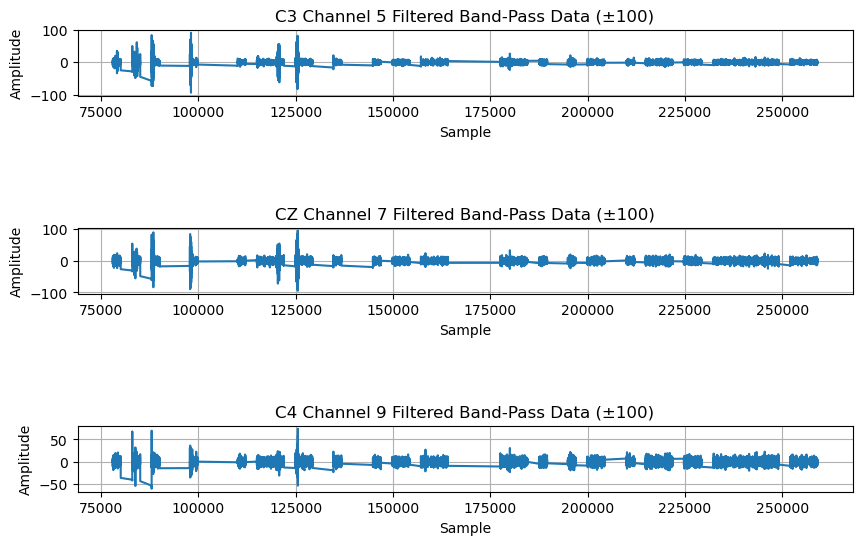

In [71]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)

axis[0].set_title('C3 Channel 5 Filtered Band-Pass Data (±100)')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7 Filtered Band-Pass Data (±100)')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9 Filtered Band-Pass Data (±100)')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0



axis[0].plot(left_imagery_band_pass_filtered['C3 Channel 5'])
axis[1].plot(left_imagery_band_pass_filtered['Cz Channel 7'])
axis[2].plot(left_imagery_band_pass_filtered['C4 Channel 9'])
plt.show()



In [72]:
# --- Updated: Strict filtering between -100 and +100 ---
def filter_band_pass_data_strict(df, threshold=100):
    mask = ((df >= -threshold) & (df <= threshold)).all(axis=1)
    return df[mask]

# Apply filtering
right_imagery_band_pass_filtered = filter_band_pass_data_strict(right_imagery_band_pass)

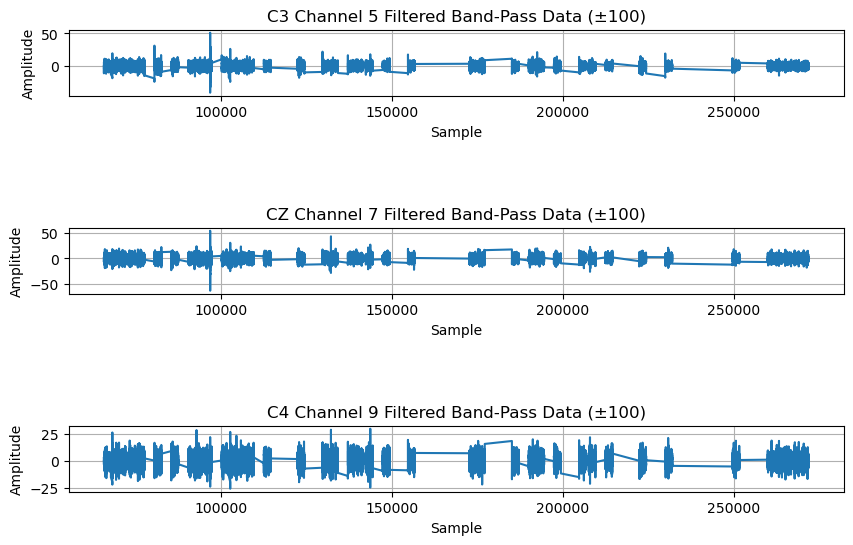

In [73]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)

axis[0].set_title('C3 Channel 5 Filtered Band-Pass Data (±100)')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7 Filtered Band-Pass Data (±100)')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9 Filtered Band-Pass Data (±100)')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0



axis[0].plot(right_imagery_band_pass_filtered['C3 Channel 5'])
axis[1].plot(right_imagery_band_pass_filtered['Cz Channel 7'])
axis[2].plot(right_imagery_band_pass_filtered['C4 Channel 9'])
plt.show()



## Spatial Filters

*Common Average Reference (CAR):*
CAR is a widely used technique in EEG signal processing to mitigate the effects of common noise across multiple electrode channels. It aims to improve the quality of EEG data by removing or reducing common sources of noise, such as the placement of electrodes, cable movement, or external electromagnetic interference or muscle activity. CAR $\rightarrow$ *Improving the signal-to-noise ratio of the EEG data.*<br/> $x_{i}(t)=x_{i}(t)-{1 \over C}\sum_{j=1}x_{j}(t); j=1,...,C$<br/>

*Process:*<br/>
 - *Step 1: Calculating the Average Signal* $\rightarrow$ Calculate the average signal across all electrodes at each time point. This average represents the common noise present in the recording.
 - *Step 2: Subtracting the Average Signal:*  $\rightarrow$ Subtract the calculated average signal from the individual electrode signals. This helps remove the common noise component.

In [74]:
def car_filter(df):
    """
    Apply Common Average Reference (CAR) to EEG data.
    Input: df (pandas DataFrame), rows = samples, columns = channels
    Output: DataFrame with CAR applied
    """
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    # compute mean across channels for each sample
    mean_signal = df.mean(axis=1)

    # subtract mean from each channel
    df_car = df.subtract(mean_signal, axis=0)

    return df_car

In [75]:
type(left_imagery_band_pass_filtered)

pandas.core.frame.DataFrame

In [76]:
type(right_imagery_band_pass_filtered)

pandas.core.frame.DataFrame

In [77]:
left_car = pd.concat([car_filter(left_imagery_band_pass_filtered[['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9']]) , left_imagery_band_pass_filtered['trig']], axis=1)
left_car

,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
78019,0.000337,0.000450,-0.000787,1
78020,-0.015135,0.010234,0.004901,1
78021,-0.170238,0.090091,0.080148,1
78022,-0.803823,0.422721,0.381102,1
78023,-2.310655,1.271183,1.039472,1
...,...,...,...,...
259019,-1.754613,-1.560717,3.315330,1
259020,-1.007335,-1.099738,2.107073,1
259021,-0.016465,-0.364511,0.380976,1
259022,0.924502,0.494084,-1.418587,1


In [78]:
right_car = pd.concat([car_filter(right_imagery_band_pass_filtered[['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9']]) , right_imagery_band_pass_filtered['trig']], axis=1)
right_car

,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
65838,0.000356,0.000380,-0.000736,-1
65839,-0.007607,-0.005859,0.013466,-1
65840,-0.088468,-0.052978,0.141446,-1
65841,-0.411622,-0.179318,0.590940,-1
65842,-1.162784,-0.341669,1.504454,-1
...,...,...,...,...
271795,0.591597,-1.222868,0.631271,-1
271796,0.223078,-0.543861,0.320783,-1
271797,0.043007,-0.041193,-0.001814,-1
271798,0.207792,0.024122,-0.231913,-1


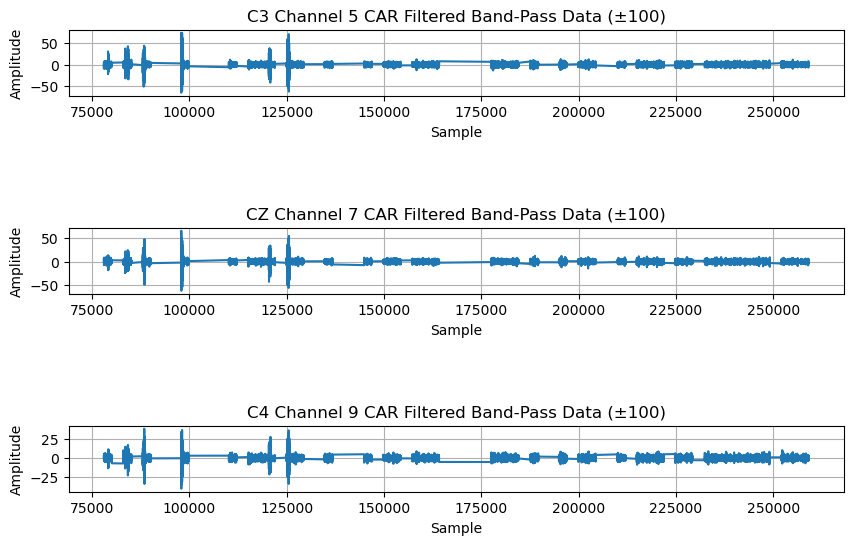

In [79]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)

axis[0].set_title('C3 Channel 5 CAR Filtered Band-Pass Data (±100)')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7 CAR Filtered Band-Pass Data (±100)')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9 CAR Filtered Band-Pass Data (±100)')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0


axis[0].plot(left_car['C3 Channel 5'])
axis[1].plot(left_car['Cz Channel 7'])
axis[2].plot(left_car['C4 Channel 9'])
plt.show()


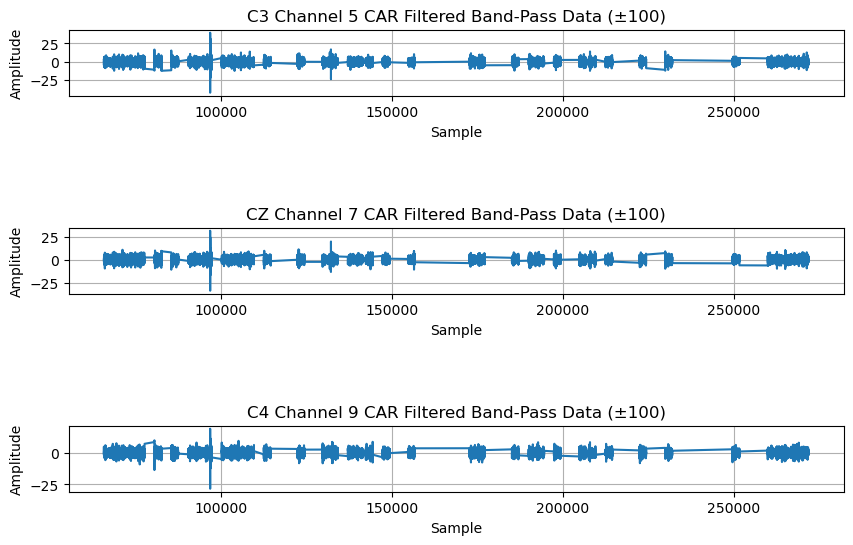

In [80]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=2)

axis[0].set_title('C3 Channel 5 CAR Filtered Band-Pass Data (±100)')
axis[0].set_xlabel('Sample')
axis[0].set_ylabel('Amplitude')
axis[0].grid(True)

axis[1].set_title('CZ Channel 7 CAR Filtered Band-Pass Data (±100)')
axis[1].set_xlabel('Sample')
axis[1].set_ylabel('Amplitude')
axis[1].grid(True)

axis[2].set_title('C4 Channel 9 CAR Filtered Band-Pass Data (±100)')
axis[2].set_xlabel('Sample')
axis[2].set_ylabel('Amplitude')
axis[2].grid(True)


line, = axis[2].plot([], [], marker='o', color='blue', linestyle='-', markersize=8)
x_data_power = []
y_data_power = []

axis_x = 0
axis_x_power = 0


axis[0].plot(right_car['C3 Channel 5'])
axis[1].plot(right_car['Cz Channel 7'])
axis[2].plot(right_car['C4 Channel 9'])
plt.show()


In [99]:
right_car

,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
65838,0.000356,0.000380,-0.000736,-1
65839,-0.007607,-0.005859,0.013466,-1
65840,-0.088468,-0.052978,0.141446,-1
65841,-0.411622,-0.179318,0.590940,-1
65842,-1.162784,-0.341669,1.504454,-1
...,...,...,...,...
271795,0.591597,-1.222868,0.631271,-1
271796,0.223078,-0.543861,0.320783,-1
271797,0.043007,-0.041193,-0.001814,-1
271798,0.207792,0.024122,-0.231913,-1


In [81]:
left_car

,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
78019,0.000337,0.000450,-0.000787,1
78020,-0.015135,0.010234,0.004901,1
78021,-0.170238,0.090091,0.080148,1
78022,-0.803823,0.422721,0.381102,1
78023,-2.310655,1.271183,1.039472,1
...,...,...,...,...
259019,-1.754613,-1.560717,3.315330,1
259020,-1.007335,-1.099738,2.107073,1
259021,-0.016465,-0.364511,0.380976,1
259022,0.924502,0.494084,-1.418587,1


In [82]:
## left and right to one big dataset
data_cleaned = pd.concat([left_car, right_car], ignore_index=True)
data_cleaned

,C3 Channel 5,Cz Channel 7,C4 Channel 9,trig
0,0.000337,0.000450,-0.000787,1
1,-0.015135,0.010234,0.004901,1
2,-0.170238,0.090091,0.080148,1
3,-0.803823,0.422721,0.381102,1
4,-2.310655,1.271183,1.039472,1
...,...,...,...,...
163823,0.591597,-1.222868,0.631271,-1
163824,0.223078,-0.543861,0.320783,-1
163825,0.043007,-0.041193,-0.001814,-1
163826,0.207792,0.024122,-0.231913,-1


In [89]:
## Changed all -1 to 0 i.e the right imagery, we have 1 and 0 for left and right respectively
data_cleaned['trig'] = data_cleaned['trig'].replace(-1, 0)
print(data_cleaned)

        C3 Channel 5  Cz Channel 7  C4 Channel 9  trig
0           0.000337      0.000450     -0.000787     1
1          -0.015135      0.010234      0.004901     1
2          -0.170238      0.090091      0.080148     1
3          -0.803823      0.422721      0.381102     1
4          -2.310655      1.271183      1.039472     1
...              ...           ...           ...   ...
163823      0.591597     -1.222868      0.631271     0
163824      0.223078     -0.543861      0.320783     0
163825      0.043007     -0.041193     -0.001814     0
163826      0.207792      0.024122     -0.231913     0
163827      0.759885     -0.434893     -0.324992     0

[163828 rows x 4 columns]


## CNNN

In [90]:
data_cleaned.describe

<bound method NDFrame.describe of         C3 Channel 5  Cz Channel 7  C4 Channel 9  trig
0           0.000337      0.000450     -0.000787     1
1          -0.015135      0.010234      0.004901     1
2          -0.170238      0.090091      0.080148     1
3          -0.803823      0.422721      0.381102     1
4          -2.310655      1.271183      1.039472     1
...              ...           ...           ...   ...
163823      0.591597     -1.222868      0.631271     0
163824      0.223078     -0.543861      0.320783     0
163825      0.043007     -0.041193     -0.001814     0
163826      0.207792      0.024122     -0.231913     0
163827      0.759885     -0.434893     -0.324992     0

[163828 rows x 4 columns]>

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [84]:
import time

In [108]:
# quick checks
print(data_cleaned.shape)          # rows, columns
print(data_cleaned.columns)        # column names
print(data_cleaned.head())         # first 5 rows
print(data_cleaned.tail())

(163828, 4)
Index(['C3 Channel 5', 'Cz Channel 7', 'C4 Channel 9', 'trig'], dtype='object')
   C3 Channel 5  Cz Channel 7  C4 Channel 9  trig
0      0.000337      0.000450     -0.000787     1
1     -0.015135      0.010234      0.004901     1
2     -0.170238      0.090091      0.080148     1
3     -0.803823      0.422721      0.381102     1
4     -2.310655      1.271183      1.039472     1
        C3 Channel 5  Cz Channel 7  C4 Channel 9  trig
163823      0.591597     -1.222868      0.631271     0
163824      0.223078     -0.543861      0.320783     0
163825      0.043007     -0.041193     -0.001814     0
163826      0.207792      0.024122     -0.231913     0
163827      0.759885     -0.434893     -0.324992     0


In [109]:
# check if a GPU is available
with_gpu = torch.cuda.is_available()
if with_gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('We are using %s now.' %device)

We are using cpu now.


In [110]:
type(data_cleaned)

pandas.core.frame.DataFrame

# Convert the data pd dataframe to dataset np

In [133]:
dataset = data_cleaned.to_numpy()

In [134]:
dataset.shape

(163828, 4)

In [135]:
dataset[-5:]

array([[ 0.5915971 , -1.22286822,  0.63127112,  0.        ],
       [ 0.22307814, -0.54386074,  0.3207826 ,  0.        ],
       [ 0.04300673, -0.04119303, -0.00181371,  0.        ],
       [ 0.20779187,  0.02412152, -0.23191339,  0.        ],
       [ 0.7598854 , -0.43489347, -0.32499193,  0.        ]])

In [136]:
type(dataset)

numpy.ndarray

# Data Segmentation Epoching
Sliding Window Extraction

In [137]:
def extract(input, n_classes, n_fea, time_window, moving):
    """
    Sliding window extraction, returns array with shape (N, n_fea*time_window + 1)
    arr, np.ndarray shape (n_samples, n_fea + 1), last column is label
    """
        
    xx = input[:, :n_fea]
    yy = input[:, n_fea:n_fea + 1]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes + 1):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)
        else:
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(0)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [179]:
n_class = 2  # 2 labels, 0 for right and 1 for left
no_feature = 3  # the number of the features/channels
segment_length = 120  # selected time window; 50=250*0.2
#LR = 0.005  # learning rate
LR = 1e-3
EPOCH = 550 #101
n_hidden = 256  # number of neurons in hidden layer
#l2 = 0.01  # the coefficient of l2-norm regularization
l2 = 1e-5

In [180]:
data_seg = extract(dataset, n_classes=n_class, n_fea=no_feature, time_window=segment_length, moving=(segment_length/2))  # 50% overlapping
print('After segmentation, the shape of the data:', data_seg.shape)

After segmentation, the shape of the data: (2730, 361)


# Split training and test data

In [181]:
# split training and test data

no_longfeature = no_feature*segment_length
data_seg_feature = data_seg[:, :no_longfeature]
data_seg_label = data_seg[:, no_longfeature:no_longfeature+1]
train_feature, test_feature, train_label, test_label = train_test_split(data_seg_feature, data_seg_label,test_size=0.1, shuffle=True)


In [182]:
train_label.shape

(2457, 1)

In [183]:
train_feature.shape

(2457, 360)

In [184]:
# normalization
# before normalize reshape data back to raw data shape
train_feature_2d = train_feature.reshape([-1, no_feature])
test_feature_2d = test_feature.reshape([-1, no_feature])

In [185]:
scaler1 = StandardScaler().fit(train_feature_2d)
train_fea_norm1 = scaler1.transform(train_feature_2d) # normalize the training data
test_fea_norm1 = scaler1.transform(test_feature_2d) # normalize the test data
print('After normalization, the shape of training feature:', train_fea_norm1.shape,
      '\nAfter normalization, the shape of test feature:', test_fea_norm1.shape)

After normalization, the shape of training feature: (294840, 3) 
After normalization, the shape of test feature: (32760, 3)


In [186]:
# after normalization, reshape data to 3d in order to feed in to LSTM
train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])
print('After reshape, the shape of training feature:', train_fea_norm1.shape,
      '\nAfter reshape, the shape of test feature:', test_fea_norm1.shape)


After reshape, the shape of training feature: (2457, 120, 3) 
After reshape, the shape of test feature: (273, 120, 3)


In [187]:
BATCH_size = test_fea_norm1.shape[0] # use test_data as batch size

## Feed data into Dataloader

In [188]:
# feed data into dataloader
train_fea_norm1 = torch.tensor(train_fea_norm1)
train_fea_norm1 = torch.unsqueeze(train_fea_norm1, dim=1).type('torch.FloatTensor').to(device)
print(train_fea_norm1.shape)
train_label = torch.tensor(train_label.flatten()).to(device)
train_data = Data.TensorDataset(train_fea_norm1, train_label)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=False)

test_fea_norm1 = torch.tensor(test_fea_norm1)
test_fea_norm1 = torch.unsqueeze(test_fea_norm1, dim=1).type('torch.FloatTensor').to(device)
test_label = torch.tensor(test_label.flatten()).to(device)


torch.Size([2457, 1, 120, 3])


In [178]:
train_loader

## CNN model build

In [197]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(2,4),
                stride=1,
                padding= (1,2)  #([1,2]-1)/2,
            ),
            nn.ReLU(),
            nn.MaxPool2d((2,4))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, (2,2), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(2,2), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(64, 256)  # Adjust to match feature map size
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(128, 2)
        


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        output = self.out(x)
        return output, x

cnn = CNN()
cnn.to(device)
print(cnn)

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay=l2)
loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 4), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (ou

In [198]:
def one_hot(y_):
    # Function to encode output labels from number indexes
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    y_ = y_.reshape(len(y_))
    y_ = [int(xx) for xx in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

In [199]:
best_acc = []
best_auc = []


# Lists to store metrics for plotting
train_losses = []
train_accs = []
test_losses = []
test_accs = []
epochs_recorded = []


# training and testing
start_time = time.perf_counter()
for epoch in range(EPOCH):
    for step, (train_x, train_y) in enumerate(train_loader):

        output = cnn(train_x)[0]  # CNN output of training data
        loss = loss_func(output, train_y.long())  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

    if epoch % 10 == 0:
        test_output = cnn(test_fea_norm1)[0]  # CNN output of test data
        test_loss = loss_func(test_output, test_label.long())

        test_y_score = one_hot(test_label.data.cpu().numpy())  # .cpu() can be removed if your device is cpu.
        pred_score = F.softmax(test_output, dim=1).data.cpu().numpy()  # normalize the output
        auc_score = roc_auc_score(test_y_score, pred_score)

        pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
        pred_train = torch.max(output, 1)[1].data.cpu().numpy()

        test_acc = accuracy_score(test_label.data.cpu().numpy(), pred_y)
        train_acc = accuracy_score(train_y.data.cpu().numpy(), pred_train)


        # Store metrics for plotting
        train_losses.append(loss.item())
        train_accs.append(train_acc)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        epochs_recorded.append(epoch)


        print('Epoch: ', epoch,  '|train loss: %.4f' % loss.item(),
              ' train ACC: %.4f' % train_acc, '| test loss: %.4f' % test_loss.item(),
              'test ACC: %.4f' % test_acc, '| AUC: %.4f' % auc_score)
        best_acc.append(test_acc)
        best_auc.append(auc_score)

current_time = time.perf_counter()
running_time = current_time - start_time
print(classification_report(test_label.data.cpu().numpy(), pred_y))
print('BEST TEST ACC: {}, AUC: {}'.format(max(best_acc), max(best_auc)))
print("Total Running Time: {} seconds".format(round(running_time, 2)))

Epoch:  0 |train loss: 0.6696  train ACC: 0.5531 | test loss: 0.6573 test ACC: 0.5934 | AUC: 0.6703
Epoch:  10 |train loss: 0.6515  train ACC: 0.5788 | test loss: 0.6402 test ACC: 0.6337 | AUC: 0.6928
Epoch:  20 |train loss: 0.6423  train ACC: 0.6117 | test loss: 0.6245 test ACC: 0.6374 | AUC: 0.7097
Epoch:  30 |train loss: 0.5619  train ACC: 0.7216 | test loss: 0.6758 test ACC: 0.6264 | AUC: 0.7087
Epoch:  40 |train loss: 0.5282  train ACC: 0.7509 | test loss: 0.7462 test ACC: 0.6154 | AUC: 0.6979
Epoch:  50 |train loss: 0.4411  train ACC: 0.7949 | test loss: 0.7867 test ACC: 0.6264 | AUC: 0.7259
Epoch:  60 |train loss: 0.5161  train ACC: 0.7399 | test loss: 0.6319 test ACC: 0.6777 | AUC: 0.7354
Epoch:  70 |train loss: 0.4315  train ACC: 0.8095 | test loss: 0.7228 test ACC: 0.6630 | AUC: 0.7237
Epoch:  80 |train loss: 0.4628  train ACC: 0.7692 | test loss: 0.9615 test ACC: 0.5861 | AUC: 0.6948
Epoch:  90 |train loss: 0.4687  train ACC: 0.7729 | test loss: 0.6762 test ACC: 0.6374 | AUC

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

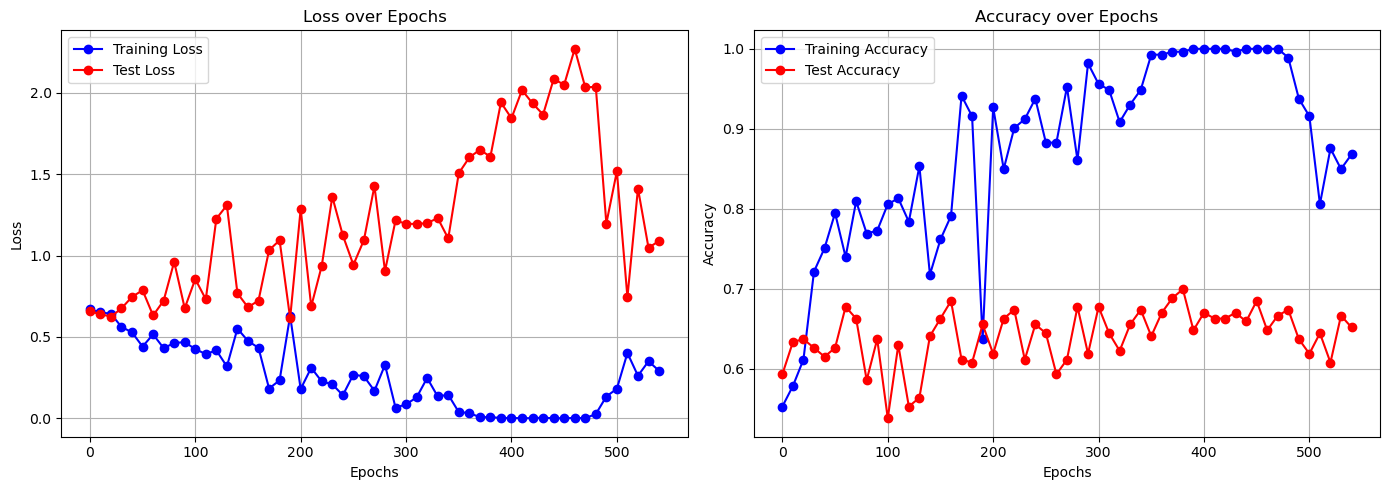

In [201]:
# Plot training and validation metrics
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_recorded, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs_recorded, test_losses, 'r-o', label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_recorded, train_accs, 'b-o', label='Training Accuracy')
plt.plot(epochs_recorded, test_accs, 'r-o', label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

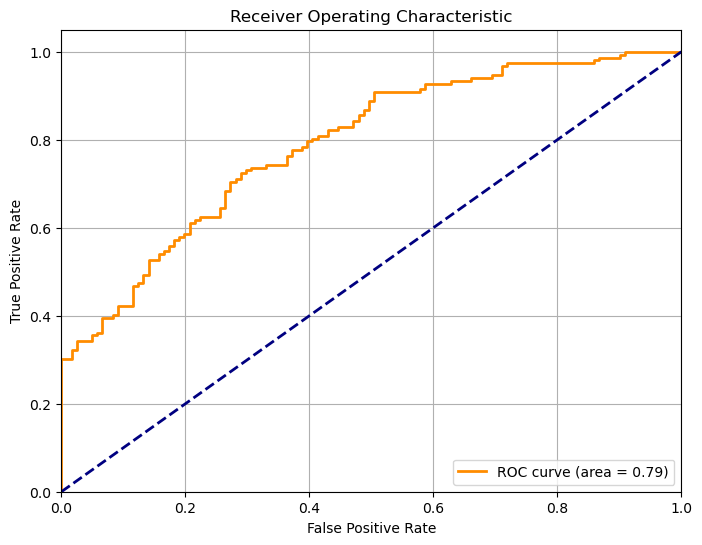

In [202]:
# Generate ROC curve
cnn.eval()                # switch to eval mode, important for dropout/batchnorm
with torch.no_grad():     # stop gradient tracking
    test_output, _ = cnn(test_fea_norm1)
    pred_score = F.softmax(test_output, dim=1).cpu().numpy()
# For binary classification, use the positive class probabilities
fpr, tpr, _ = roc_curve(test_label.cpu().numpy(), pred_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

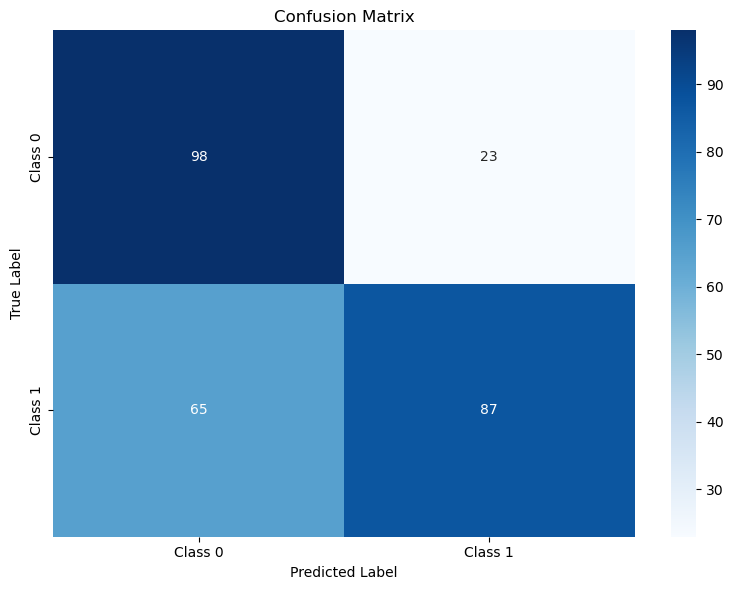

In [203]:
# Generate confusion matrix
pred_y = torch.max(test_output, 1)[1].cpu().numpy()
cm = confusion_matrix(test_label.cpu().numpy(), pred_y)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(n_class)],
            yticklabels=[f'Class {i}' for i in range(n_class)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [204]:
# Print final metrics
print("===== Final Model Performance Metrics =====")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("=========================================")

# Classification report (already in your code but shown again for completeness)
print(classification_report(test_label.cpu().numpy(), pred_y))

===== Final Model Performance Metrics =====
Test Accuracy: 0.6520
Test Loss: 1.0894
ROC AUC Score: 0.7898
              precision    recall  f1-score   support

         0.0       0.60      0.81      0.69       121
         1.0       0.79      0.57      0.66       152

    accuracy                           0.68       273
   macro avg       0.70      0.69      0.68       273
weighted avg       0.71      0.68      0.68       273



## Save the Model After Training